# Fuzy Deep Cuts

The ellipsoid method is a method for showing that the polytope $P = \{x \in \mathbb{R}^n : Ax \geq b\}$ is non-empty. Here, $A$ is an $m \times n$ matrix with integer entries and $b$ is a vector of length $m$ also of integer entries.

Given a point $x' \in \mathbb{R}^n$, there must be some algorithm which is able to see if $a_i^T x' \geq b_i$ for all $i \in \mathbb{N}_m$. That is, we must be able to find the violated row constraints.

Classically, this is done by simply computing each inner product directly, which takes $\mathcal{O}(mn \textbf{ log}_2(U))$ itterations in the worst case. Here, $U$ is the largest magnitude entry of either $A$ or $b$.

Using a quantum computer, we can instead calculate the inner product of each of the rows simultaniously. Unfortunately, by the nature of quantum states, we cannot observe these calculations directly and must instead rely upon Quantum Tomography to reconstrut each state.

Let $M = \lceil \textbf{log}_2(m) \rceil$ and $N = \lceil \textbf{log}_2(n) \rceil$, so that the data may be encoded as quantum states. The circuit below relies upon QRAM being able to encode the state $| a_i \rangle$ when given the state $| i \rangle$ as an input. The circuit is made of three registers. The first is the ancilia qubit, the second is the index register, and the third is the vector register. The probability that the first register measures $| 0 \rangle$ will be $\frac{1}{2}(1+\langle a_i|x \rangle)$.

Therefore, using quantum tomography, we can reconstruct $\langle a_i | x \rangle$ for each $i$. Additionally, we can do this up to arbitrary persision $\epsilon$ using $\mathcal{O}(\frac{m}{\epsilon^2})$ shots. This will give an advantage over the classical case so long as $\mathcal{O}(\frac{1}{\epsilon^2}) \leq \mathcal{O}(n\textbf{ log}_2(U))$. This variable precision is why the term "fuzy" is used. The "deep cut" is used because we are able to see which constaint is the most violated, that is the index $i$ for which $b - a_i^T x$ is largest. If all constraints are feasible, then $\forall i \in \mathbb{N}_m; b_i - a_i^T x \leq 0$.

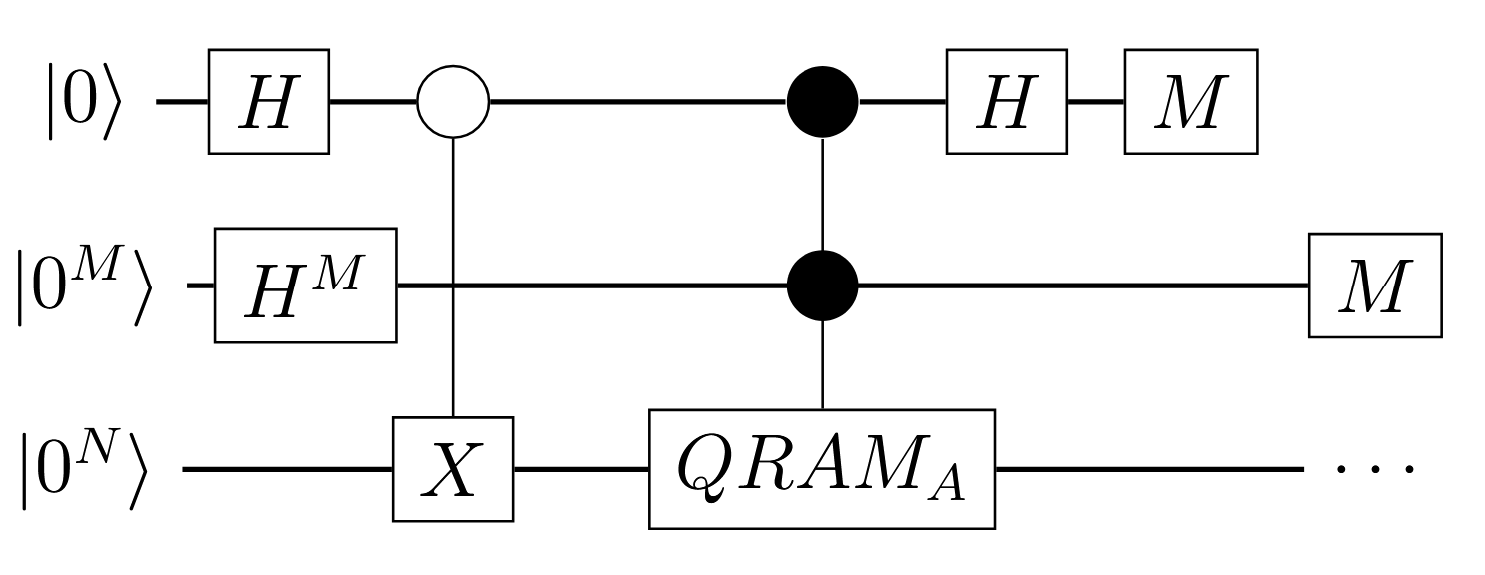

In [3]:
# Quantum Simulation Stuff
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import UnitaryGate
import qiskit.circuit.library.standard_gates
from qiskit.circuit.library.standard_gates import XGate, HGate, IGate

from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
simulator = AerSimulator()

# Useful and known
import numpy as np
from numpy import linalg
import math
import scipy.linalg as la
import random as rd

# Linear Algebra Stuff
from sympy import Matrix
from sympy.physics.quantum import TensorProduct

# For graphing data and drawing circuits
import matplotlib.pyplot as plt

### Surprise Tools That Will Help Us Later

In [4]:
def transpose_row(row):
    new= []
    for element in range(len(row)):
        new.append([row[element]])
        
    return np.array(new)

In [5]:
# Creates a unitary which encodes the state |v>
def create_unitary(v):
    return np.hstack((v,la.null_space(v.T)))

In [6]:
def generate_binary_strings(bit_count):
    binary_strings = []
    def genbin(n, bs=''):
        if len(bs) == n:
            binary_strings.append(bs)
        else:
            genbin(n, bs + '0')
            genbin(n, bs + '1')


    genbin(bit_count)
    return binary_strings

# Toy Problem

Here, we construct the simplest problem this circuit could possibly solve. It will work on a single qubit and a single constraint. 

We want to determine if for $A = \begin{pmatrix} 0 & 1 \end{pmatrix}x \geq \begin{pmatrix} 0.5 \end{pmatrix}$ has a feasible solution. Thefore, our $a_0 = | 1 \rangle$ and we initialize with $x =  | 0 \rangle$.

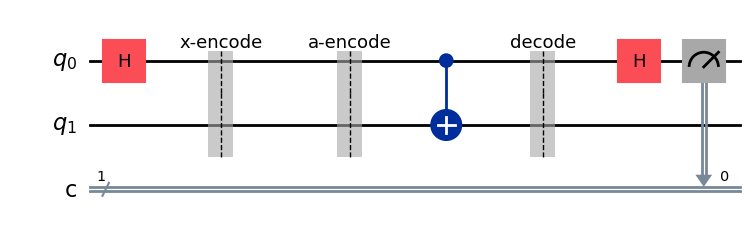

In [7]:
qc = QuantumCircuit(2,1)

# Entangle the Auxilary Qubit
qc.h(0)

# Entangle the x-state(nothing since x = |0>)
qc.barrier(label = 'x-encode')

# Entangle the a_i
qc.barrier(label = 'a-encode')
qc.cx(0,1)

# Un-H-gate
qc.barrier(label = 'decode')
qc.h(0)

# Measurement
qc.measure(0,0)

qc.draw(output='mpl')

In [8]:
# Shots = $\epsilon^2$. Since it's 100^2, we can be confident upto the 2nd decimal place.
exactness = 3
epsilon = 10**(-exactness)
shots = int(1/(epsilon**2))

job = transpile(qc,backend=simulator)
result = simulator.run(job, shots=shots).result()

exact = (2*result.get_counts(qc)['0']-shots)/shots
inner_product = f"%.{exactness-1}f"%exact

print(inner_product)

-0.00


# Multiple Constraint Toy Problem

$A = 
\begin{pmatrix}
    1 & 0\\
    0 & 1\\
    \frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}\\
    1 & 0\\
\end{pmatrix} x \geq
\begin{pmatrix}
    \frac{1}{6} \\
    \frac{1}{6} \\
    \frac{1}{2} \\
    0\\
\end{pmatrix}$.

Here, the last constraint is a dummy constraint used to ensure $M$ is a power of 2.

Can we find the violated rows of A?

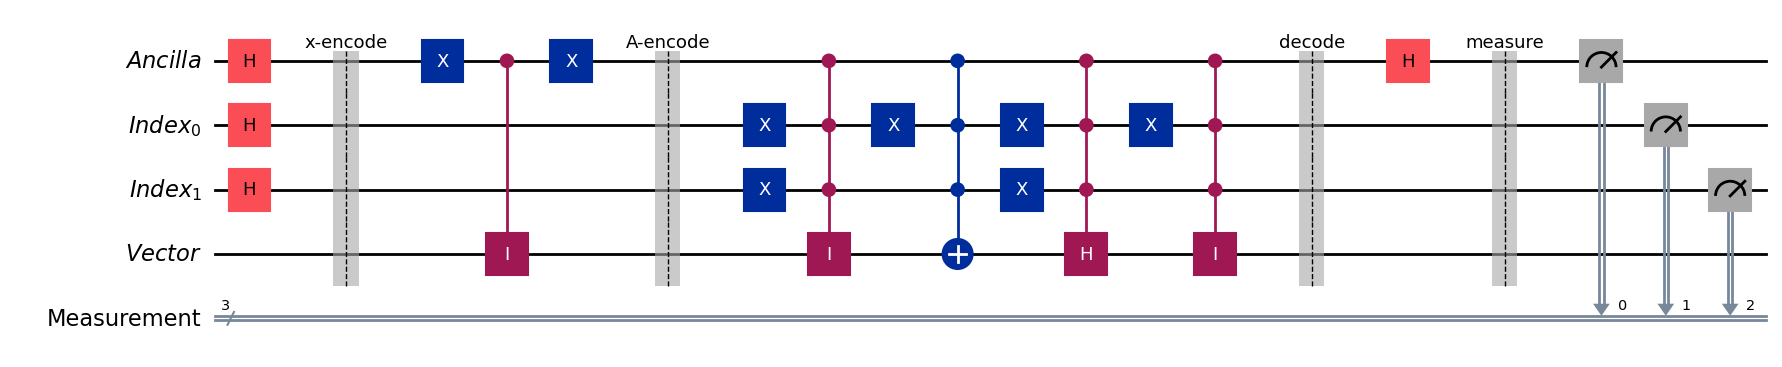

In [9]:
# Preping the different Registers and then creating the circuit
Ancilla = QuantumRegister(1, name='Ancilla')

M = 2
Index = QuantumRegister(M, name='Index')

N = 1
Vector = QuantumRegister(N, name='Vector')

Measure = ClassicalRegister(3, name='Measurement')

mctp = QuantumCircuit(Ancilla, Index, Vector, Measure)

# Hadamard Gates
mctp.h(0)
mctp.h([1,2])

# Encoding X
# Do nothing for this circuit as x will inicialize as 0
mctp.barrier(label = 'x-encode')
mctp.x(0)
mctp.append(IGate().control(1),[0,3])
mctp.x(0)

# Encoding A matrix
# Here, for every binary possibility of the qubits passing through, I have to manually encode the row of A they call.
mctp.barrier(label = 'A-encode')

mctp.x([1,2])
mctp.append(IGate().control(3),[0,1,2, 3])
mctp.x([1])

mctp.append(XGate().control(3),[0,1,2, 3])
mctp.x(2)

mctp.x(1)
mctp.append(HGate().control(3),[0,1,2, 3])
mctp.x(1)

mctp.append(IGate().control(3),[0,1,2, 3])



mctp.barrier(label = 'decode')
mctp.h(0)

mctp.barrier(label = 'measure')
mctp.measure([0,1,2],[0,1,2])

mctp.draw(output='mpl')

In [10]:
# Shots = $\epsilon^2$. Since it's 100^2, we can be confident upto the 2nd decimal place.

# Here, if the output for an index is negative, it means that row constraint was failed.
exactness = 2
shots = M*10**(2*exactness)

job = transpile(mctp,backend=simulator)
result = simulator.run(job, shots=shots).result()

b_vect = {'00':1/6, '01':1/6, '10':1/2, '11':0}

for index in generate_binary_strings(M+1):
    if index[-1] == '0':
        try:
            inner_product = 2**(M+1) * (result.get_counts(mctp)[index]/shots)-1
            constraint_success = inner_product-b_vect[index[:-1]]
            known_constraint_success = f"%.{exactness-1}f"%constraint_success
            
            print(f'{index[:-1]}: {known_constraint_success}')
        
        except:
            print(f'{index}: 0')

00: 0.8
01: -0.1
10: 0.2
11: 1.0


# A decoren encoded A
As seen in the example above, to manually program in the A-encoding would be far too difficult. This is because it would take encoding an enormous number of control gates, and it would require me to encode each row of A as a unitary by hand. Therefore, I'll create a $\textbf{QRAM}$ subroutine which will be able to encode $|a_i\rangle$ when the key $|i\rangle$ is used as the control. The assumption that such systems can be efficient is one common to the field.

In [11]:
A_test = np.array([[1.0, 0.0],
              [0.0, 1.0],
              [math.sqrt(2.0)/2.0, math.sqrt(2.0)/2.0],
              [1.0, 0.0]
             ])

In [12]:
def qram_unitaries(A):
    A_unit = {}
    
    for index in range(len(A)):
        A_unit[index] = UnitaryGate(create_unitary(transpose_row(A[index])), label=f'a_{index}').control(int(math.sqrt(len(A))))
        
    return A_unit

In [13]:
def qram_circuit(A):
    M = int(math.sqrt(len(A)))
    N = int(math.sqrt(len(A[0])))
    
    A_unitary = qram_unitaries(A)
    
    binary_encoding = QuantumRegister(M, name='BE')
    unitaries = QuantumRegister(N, name='U')
    
    qram_circuit = QuantumCircuit(binary_encoding,unitaries)
    
    for index in range(len(A)):
        for wire in range(M):
            if index%(wire+1) == 0:
                qram_circuit.x(wire)
            
        qram_circuit.append(A_unitary[index], range(int(math.sqrt(len(A)))+1))
    
    return qram_circuit

In [14]:
qram_a = qram_circuit(A_test)

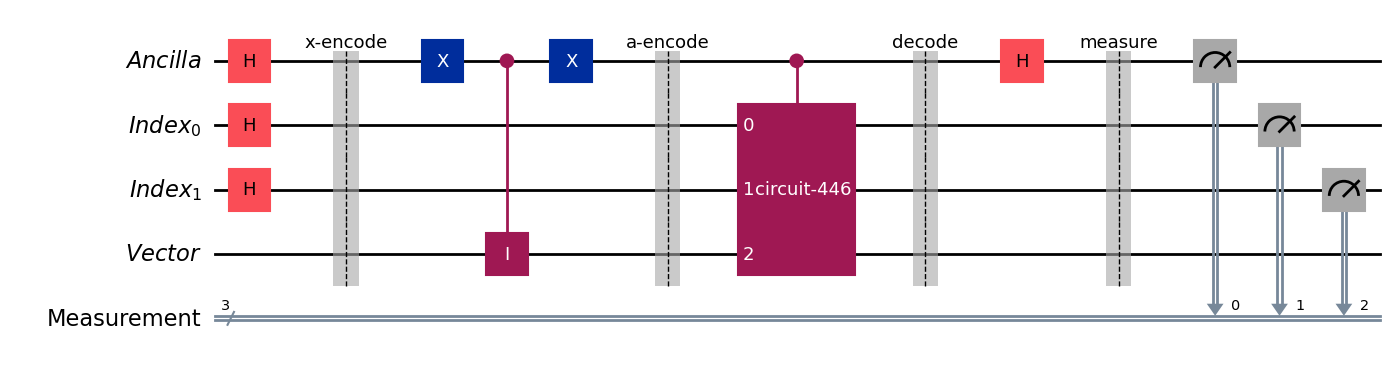

In [15]:
# Here we take the code from before
# Preping the different Registers and then creating the circuit
Ancilla = QuantumRegister(1, name='Ancilla')

M = 2
Index = QuantumRegister(M, name='Index')

N = 1
Vector = QuantumRegister(N, name='Vector')

Measure = ClassicalRegister(3, name='Measurement')

mctp = QuantumCircuit(Ancilla, Index, Vector, Measure)

# Hadamard Gates
mctp.h(0)
mctp.h([1,2])

# Encoding X
# Do nothing for this circuit as x will inicialize as 0
mctp.barrier(label = 'x-encode')
mctp.x(0)
mctp.append(IGate().control(1),[0,3])
mctp.x(0)

# Encoding A matrix
# Here, for every binary possibility of the qubits passing through, I have to manually encode the row of A they call.
mctp.barrier(label = 'a-encode')
qram_a = qram_circuit(A_test).to_gate().control(1)
mctp.append(qram_a, [0,1,2,3])

mctp.barrier(label = 'decode')
mctp.h(0)

mctp.barrier(label = 'measure')
mctp.measure([0,1,2],[0,1,2])

mctp.draw(output='mpl')

# Non-$|0 \rangle$ $x$-input

In [16]:
def create_x_gate(x):
    x_gate = UnitaryGate(create_unitary(x.T), label='x_circuit').control(1)
    return x_gate

In [17]:
x_test = np.array([[math.sqrt(99)/10, 1/10]])

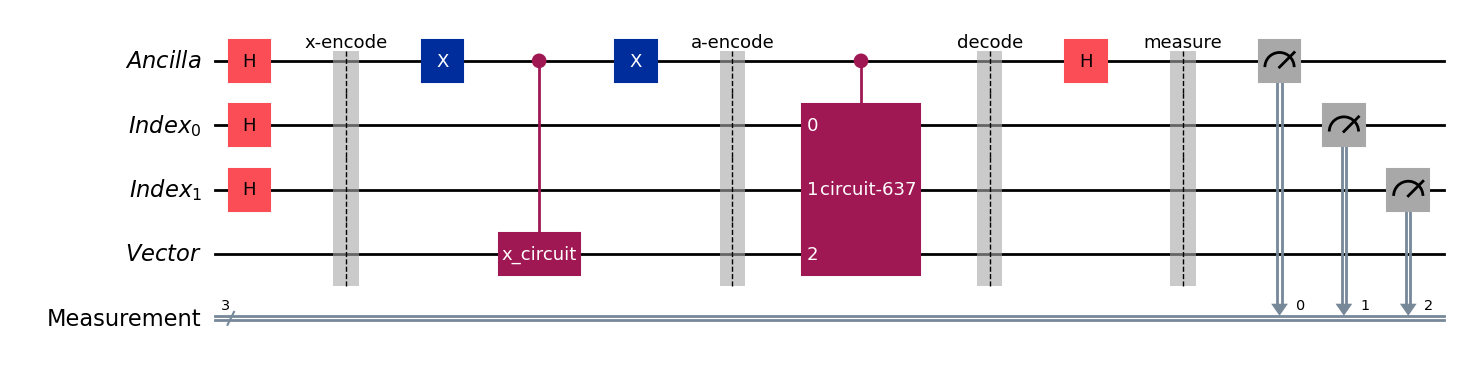

In [18]:
# Here we take the code from before
# Preping the different Registers and then creating the circuit
Ancilla = QuantumRegister(1, name='Ancilla')

M = 2
Index = QuantumRegister(M, name='Index')

N = 1
Vector = QuantumRegister(N, name='Vector')

Measure = ClassicalRegister(3, name='Measurement')

mctp = QuantumCircuit(Ancilla, Index, Vector, Measure)

# Hadamard Gates
mctp.h(0)
mctp.h([1,2])

# Encoding X
# Do nothing for this circuit as x will inicialize as 0
mctp.barrier(label = 'x-encode')
mctp.x(0)
x_gate = create_x_gate(x_test)
mctp.append(x_gate, [0,-1])
mctp.x(0)

# Encoding A matrix
# Here, for every binary possibility of the qubits passing through, I have to manually encode the row of A they call.
mctp.barrier(label = 'a-encode')
qram_a = qram_circuit(A_test).to_gate().control(1)
mctp.append(qram_a, [0,1,2,3])

mctp.barrier(label = 'decode')
mctp.h(0)

mctp.barrier(label = 'measure')
mctp.measure([0,1,2],[0,1,2])

mctp.draw(output='mpl')

In [19]:
# Shots = $\epsilon^2$. Since it's 100^2, we can be confident upto the 2nd decimal place.

# Here, if the output for an index is negative, it means that row constraint was failed.
exactness = 3
shots = M*10**(2*exactness)

job = transpile(mctp,backend=simulator)
result = simulator.run(job, shots=shots).result()

b_vect = {'00':1/6, '01':1/6, '10':1/2, '11':0}

for index in generate_binary_strings(M+1):
    if index[-1] == '0':
        try:
            inner_product = 2**(M+1) * (result.get_counts(mctp)[index]/shots)-1
            constraint_success = inner_product-b_vect[index[:-1]]
            known_constraint_success = f"%.{exactness-1}f"%constraint_success
            
            print(f'{index[:-1]}: {known_constraint_success}')
        
        except:
            print(f'{index}: 0')

00: 0.83
01: -0.06
10: 0.27
11: 0.99


# General Circuit Function
Creates a general circuit with the input of A and x which will be able to produce the inner product state

In [20]:
def create_inner_prod_circuit(A,x):
    # Here we take the code from before
    # Preping the different Registers and then creating the circuit
    Ancilla = QuantumRegister(1, name='Ancilla')

    # Number of qubits needed for Constraint indicies
    M = int(math.log(len(A),2))
    Index = QuantumRegister(M, name='Index')

    # Number of qubits needed for dimension of solution vector
    N = int(math.log(len(A[0]),2))
    Vector = QuantumRegister(N, name='Vector')

    Measure = ClassicalRegister(3, name='Measurement')

    # General Inner Product Circuit
    gipc = QuantumCircuit(Ancilla, Index, Vector, Measure)

    # Hadamard Gates
    gipc.h(0)
    gipc.h([1,2])

    # Encoding X
    # Do nothing for this circuit as x will inicialize as 0
    gipc.barrier(label = 'x-encode')
    gipc.x(0)
    x_gate = create_x_gate(x_test)
    gipc.append(x_gate, [0,-1])
    gipc.x(0)

    # Encoding A matrix
    # Here, for every binary possibility of the qubits passing through, I have to manually encode the row of A they call.
    gipc.barrier(label = 'a-encode')
    qram_a = qram_circuit(A_test).to_gate().control(1)
    gipc.append(qram_a, [0,1,2,3])

    gipc.barrier(label = 'decode')
    gipc.h(0)

    gipc.save_statevector()
    
    gipc.barrier(label = 'measure')
    gipc.measure([0,1,2],[0,1,2])
    
    return gipc

In [21]:
ipc = create_inner_prod_circuit(A_test,x_test)

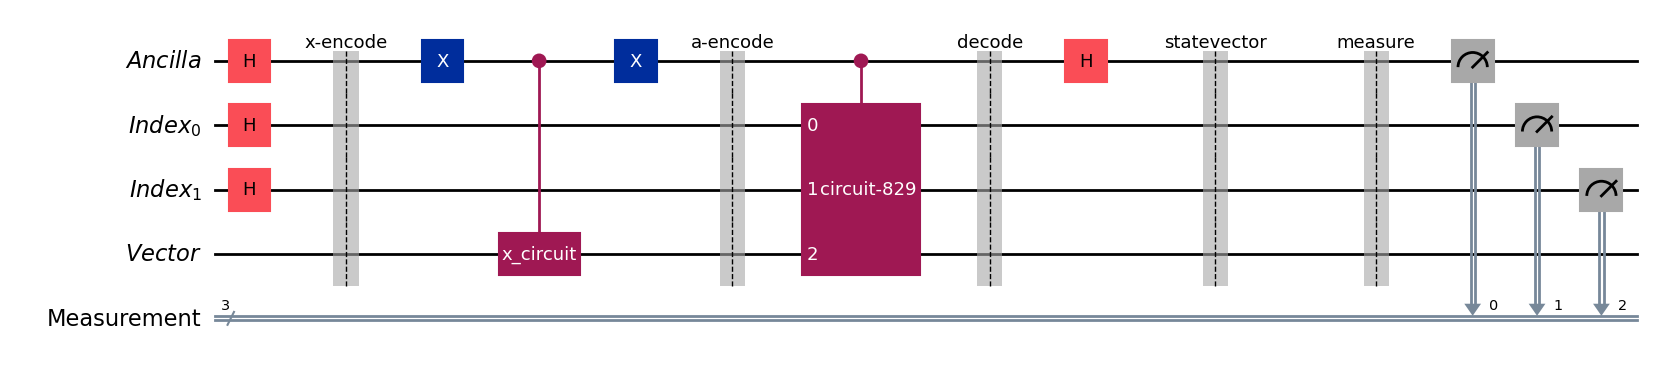

In [22]:
ipc.draw(output='mpl')

In [23]:
# Shots = $\epsilon^2$. Since it's 100^2, we can be confident upto the 2nd decimal place.

# Here, if the output for an index is negative, it means that row constraint was failed.
exactness = 2
shots = M*10**(2*exactness)

job = transpile(ipc,backend=simulator)
result = simulator.run(job, shots=shots).result()
statevector = result.get_statevector()

In [24]:
b_vect = {'00':1/6, '01':1/6, '10':1/2, '11':0}

for index in generate_binary_strings(M+1):
    if index[-1] == '0':
        try:
            inner_product = 2**(M+1) * (result.get_counts(ipc)[index]/shots)-1
            constraint_success = inner_product-b_vect[index[:-1]]
            known_constraint_success = f"%.{exactness-1}f"%constraint_success
            
            print(f'{index[:-1]}: {known_constraint_success}')
        
        except:
            print(f'{index}: 0')

00: 0.8
01: -0.1
10: 0.3
11: 1.0


# Escaping Tomography
In order to reconstruct the quantum data, I must use an exponential number of shots. Therefore, I must find a way to access the useful information, if a constraint violated, without measurement this percise.

The quantum state before measurement will be a vector $p$ such that $p_i = \sqrt{\frac{1}{2}(1 - \langle x|a_i \rangle)}$. 

Given that our input $b$, where we are trying to solve $Ax \geq b$, we should be able to find a way to encode $k\sqrt{\frac{1}{2}(1-b_i)}$ as a quantum state where $k$ is a known constant. Using that quantum state, called $| \psi_b \rangle$, we can then take the difference of that state and $p$. We can then use a false negative test (from Naniccini) to test if each index is negative and use that to see if there is a violated constraint.

#### Scale A, b, and $| \psi_b \rangle$ to be quantum encodeable

In [88]:
def condition_matrix_and_vector(A,b):
    A_new = []
    b_new = b.copy()
    
    # Ensures the new dimension will be a power of 2, and each constraint will have 0 as its last entry
    dim_new = 2**math.ceil(math.log(len(A[0])+1,2))
    dim_dif = dim_new - len(A[0])
    
    # Get the matrix A to be of the proper dimension so its rows can be encoded as quantum states
    # This also forses there the be zeros in the last column
    # This is so we can initialize the center to have a 1 in the last column so it will always be a unit vector
    for row in range(len(A)):
        new_row = list(A[row])
        
        for zero in range(dim_dif):
            new_row.append(0.0)
        
        A_new.append(new_row)
        
    A_new = np.array(A_new)
    
    # Here, we normalize the rows of A so that they can be encoded as quantum states
    # We scale the entries of b so that the polytope defined remains the same
    for index in range(len(A)):
        b_new[index] = b_new[index]/np.linalg.norm(A_new[index])
        A_new[index] = A_new[index]/np.linalg.norm(A_new[index])
        A_new = list(A_new)
        
    # Here, we scale b so that we can acurately tell if we passed or failed the constraint
    # It must be that the largest magnitude entry in b is at most 1, since we test constraints by multiply two unit vectors
    # This is a consequence of the Cauchey-Schwartz inequallity
    k = 2*np.linalg.norm(b_new)
    b_new = b_new/k
    b_new = list(b_new)
    
    # Add in dummy rows so it becomes a power of 2
    M = math.ceil(math.log(len(A_new[0]),2)+1)
    diff = M-len(A_new)
    
    for row in range(diff+1):
        A_new.append(np.zeros(dim_new))
        b_new.append([0])
    
    return np.array(A_new), np.array(b_new),k

In [94]:
def create_psi_b(b_vect):
    M = len(b_vect)
    
    b_total = 0.5*sum(b_vect)
    
    k = (M/2 - b_total)**(0.5)
    
    psi_b = np.zeros(len(b_vect))
    
    for index in range(M):
        psi_b[index] = (k)**(-1) * math.sqrt(0.5- 0.5*b_vect[index])
    
    return psi_b

In [95]:
A = np.array([[1,0],
              [0,1],
              [1,1]
             ])

b = np.array([[1],
              [1],
              [3]
             ])

In [96]:
(A_new, b_new, k) = condition_matrix_and_vector(A,b)
psi_b = create_psi_b(b_new)

A_new, b_new, psi_b

C:\Users\Ben\AppData\Local\Temp\ipykernel_16320\3003720311.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  psi_b[index] = (k)**(-1) * math.sqrt(0.5- 0.5*b_vect[index])


(array([[1.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.70710678, 0.70710678, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]]),
 array([[0.20412415],
        [0.20412415],
        [0.40824829],
        [0.        ]]),
 array([0.5       , 0.5       , 0.43113879, 0.56046351]))

#### Sign of Quantum States

In [ ]:
# Suppose psi is a quantum state with 2^(m_dim) qubits with vector representation v in the computational basis.
# We want this circuit to return 1 if the entry at that index is negative
def sign_of_quantum_state_circuit(num_qubits, index):

#### Take the difference of quantum states

In [ ]:
# This is actually just like the inner_product 
def difference_of_quantum_states(a,b):
    # Here we take the code from before
    # Preping the different Registers and then creating the circuit
    Ancilla = QuantumRegister(1, name='Ancilla')

    # Number of qubits needed for Constraint indicies
    M = int(math.log(len(A),2))
    Index = QuantumRegister(M, name='Index')

    # Number of qubits needed for dimension of solution vector
    N = int(math.log(len(A[0]),2))
    Vector = QuantumRegister(N, name='Vector')

    Measure = ClassicalRegister(3, name='Measurement')

    # General Inner Product Circuit
    gipc = QuantumCircuit(Ancilla, Index, Vector, Measure)

    # Hadamard Gates
    gipc.h(0)
    gipc.h([1,2])

    # Encoding X
    # Do nothing for this circuit as x will inicialize as 0
    gipc.barrier(label = 'x-encode')
    gipc.x(0)
    x_gate = create_x_gate(x_test)
    gipc.append(x_gate, [0,-1])
    gipc.x(0)

    # Encoding A matrix
    # Here, for every binary possibility of the qubits passing through, I have to manually encode the row of A they call.
    gipc.barrier(label = 'a-encode')
    qram_a = qram_circuit(A_test).to_gate().control(1)
    gipc.append(qram_a, [0,1,2,3])

    gipc.barrier(label = 'decode')
    gipc.h(0)

    gipc.save_statevector()
    
    gipc.barrier(label = 'measure')
    gipc.measure([0,1,2],[0,1,2])
    
    
    
    return gipc

#### Test if $\langle a_i|x \rangle - b_i \geq 0$ by seeing if $\sqrt{\frac{1}{2}(1-\langle x|a_i \rangle)}-\sqrt{\frac{1}{2}(1-b_i)}$ is negative